# Qiskit Workshop: Variational Algorithms

In [5]:
import numpy as np

Install `scipy`, if needed.

In [6]:
!pip install scipy

## Operators

In [7]:
from qiskit.quantum_info import Pauli

### Identity operator

In [8]:
I = Pauli('I')
I.to_matrix()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

### Pauli X operator

In [9]:
X = Pauli('X')
X.to_matrix()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

The X (NOT) gate in a circuit is equivalent to the Pauli X operator

In [10]:
from qiskit.circuit.library import XGate

XGate().to_matrix()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

### Pauli Y operator

In [11]:
Y = Pauli('Y')
Y.to_matrix()

array([[0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j]])

### Pauli Z operator

In [12]:
Z = Pauli('Z')
Z.to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

## Hamiltonians

In [13]:
from qiskit.quantum_info import Operator

II = Operator(Pauli('II'))
IZ = Operator(Pauli('IZ'))
XI = Operator(Pauli('XI'))

hamiltonian = 1.0*II + 2.0*IZ + 3.0*XI
hamiltonian

Operator([[ 3.+0.j,  0.+0.j,  3.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  3.+0.j],
          [ 3.+0.j,  0.+0.j,  3.+0.j,  0.+0.j],
          [ 0.+0.j,  3.+0.j,  0.+0.j, -1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [14]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
hamiltonian

SparsePauliOp(['II', 'IZ', 'XI'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

### Hamiltonians as observables

Create a simple state. In this case, two qubits in uniform superposition, i.e. the "plus" state

In [15]:
from qiskit.quantum_info import Statevector

plus_state = Statevector.from_label('++')
plus_state

Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))


Compute the expectation value given the Hamiltonian operator as an observable

In [16]:
exp_val = plus_state.expectation_value(hamiltonian)
exp_val

(3.9999999999999982+0j)

## Variational Quantum Eigensolver

<img src=https://qiskit.org/documentation/nature/_images/vqe.png width=1000px>

### Parameterized circuits for Ansatz

You can prepare trial states by using a parameterized circuit. Qiskit has a number of circuit templates that you can use for this purpose.

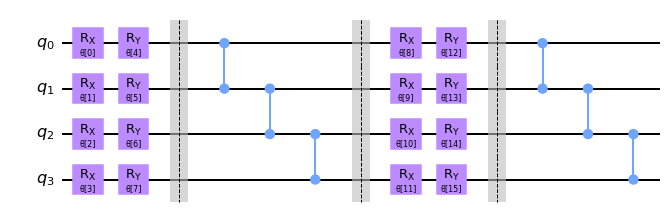

In [17]:
from qiskit.circuit.library import TwoLocal

tl_qc = TwoLocal(num_qubits=4,
                 rotation_blocks=['rx', 'ry'],
                 entanglement_blocks=['cz'],
                 entanglement='linear',
                 reps=2,
                 skip_final_rotation_layer=True,
                 insert_barriers=True
                )
tl_qc.decompose().draw()

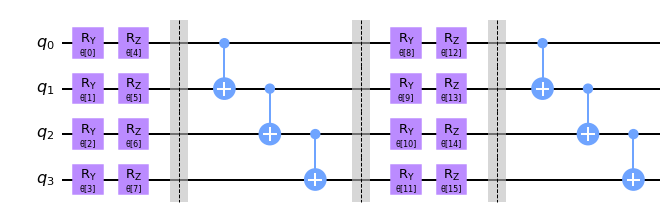

In [18]:
from qiskit.circuit.library import EfficientSU2

su2_qc = EfficientSU2(num_qubits=4,
                     entanglement='linear',
                     reps=2,
                     skip_final_rotation_layer=True,
                     insert_barriers=True
                    )
su2_qc.decompose().draw()

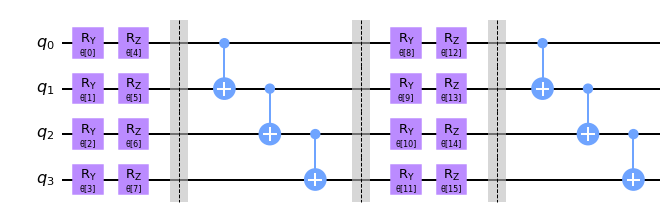

In [19]:
from qiskit.circuit.library import RealAmplitudes

su2_qc = EfficientSU2(num_qubits=4,
                     entanglement='linear',
                     reps=2,
                     skip_final_rotation_layer=True,
                     insert_barriers=True
                    )
su2_qc.decompose().draw()

### Constructing the VQE algorithm

First, we construct a Hamiltonian operator that represents our problem, and use it as the observable in the VQE algorithm. Below is a example Hamiltonian.

In [20]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

Next, define the ansatz circuit.

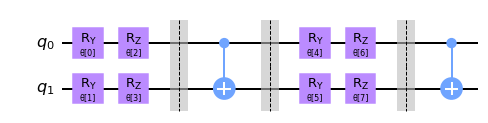

In [21]:
ansatz = EfficientSU2(num_qubits=hamiltonian.num_qubits,
                      entanglement='linear',
                      reps=2,
                      skip_final_rotation_layer=True,
                      insert_barriers=True
                     )
ansatz.decompose().draw()

Now, define a cost function that evaluates the expectation value of the observable given the state prepared by the ansatz circuit.

In [22]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: cost estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

For the classical optimization algorithm that tunes the circuit parameters, we will use the `scipy.optimize` module. This contains the `minimize` function, which implments several different classical optimization algorithms including:

- Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm
- Sequential Least Squares Programming (SLSQP)
- Constrained Optimization BY Linear Approximation (COBYLA)

Documentation on the `scipy.minimize`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Here, we use the COBYLA algorithm.

In [23]:
from qiskit.primitives import Estimator
from scipy.optimize import minimize

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

estimator = Estimator(options={"shots": int(1e4)})
result = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla")
result

     fun: -0.6972983611036325
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 112
  status: 1
 success: True
       x: array([3.77854895, 1.56535172, 7.23925317, 1.92260042, 1.47360902,
       3.73788663, 0.20129938, 5.96699091])

In [24]:
import qiskit.tools.jupyter

%qiskit_version_table